In [9]:
from models_and_tools.ACGAN_paper import *
from models_and_tools.ACGAN_simple import *
from models_and_tools.functions import *

device = 'cuda'

Downloading the model and parameters

In [10]:
netG = Generator(conf).to(device)
netD = Discriminator(conf).to(device)
# Load the weights back into the models
netG.load_state_dict(torch.load('netG200.pth'))
netD.load_state_dict(torch.load('netD200.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 

In [11]:
# Load a pre-trained ResNet model
model = resnet50(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Removing the final layer
feature_extractor.eval()

C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [12]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def get_features(image, feature_extractor):
	""" Convert image to tensor, normalize, and pass through the model """
	image = normalize(image).unsqueeze(0).to(device)  # Add batch dimension
	with torch.no_grad():
		features = feature_extractor(image)
	return features.flatten()


def cosine_similarity(feat1, feat2):
	""" Compute the cosine similarity between two feature vectors """
	return torch.nn.functional.cosine_similarity(feat1, feat2, dim=0)


def cosine_similarities(features1, features2):
	num_images = len(features1)
	similarities = []
	for i in range(num_images):
		sim = cosine_similarity(features1[i].cpu(), features2[i].cpu())
		similarities.append(sim)
	return similarities


num_images = 1000
fake_labels = torch.randint(0, conf.num_classes, (num_images,), device=device)
fake_labels2 = torch.randint(0, conf.num_classes, (num_images,), device=device)
generated_images1 = generate_images(netG, num_images, fake_labels)
generated_images2 = generate_images(netG, num_images, fake_labels2)


features1 = [get_features(image, feature_extractor) for image in generated_images1]
features2 = [get_features(image, feature_extractor) for image in generated_images2]




# print(f"Similarity: {similarity.item()}")

In [13]:
similarities = cosine_similarities(features1, features2)

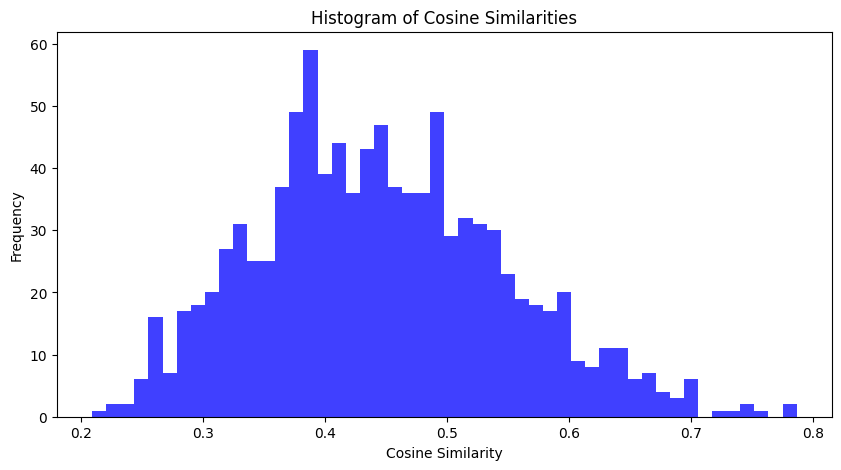

In [14]:
# Plot the mean SSIM values
n_bins = 50  # You can change the number of bins based on how detailed you want the histogram to be
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=n_bins, alpha=0.75, color='blue')
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()

In [15]:
def get_n_images_of_class(images, labels, class_x, n):
	"""
    Fetches N images of a specified class X from the image and label arrays.
    Returns:
    - selected_images (numpy array): An array of N images belonging to class X.
    """
	indices_of_class_x = np.where(labels == class_x)[0]
	# Check if there are enough samples of class_x
	if len(indices_of_class_x) < n:
		print(
			f"Warning: Only {len(indices_of_class_x)} images found for class {class_x}, which is less than {n} requested.")
		n = len(indices_of_class_x)  # Adjust n to the maximum available if less than requested
	# Randomly select n indices from those that belong to class_x
	selected_indices = np.random.choice(indices_of_class_x, n, replace=False)
	# Fetch the images corresponding to these indices
	selected_images = images[selected_indices]
	return selected_images



In [16]:
transform = transforms.Compose([
	transforms.Resize((conf.img_size, conf.img_size)),  # Resize the image
	transforms.ToTensor(),  # Convert the image to a tensor
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])
# downloading the CIFAR10 dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=conf.batch_size, shuffle=True)
# getting images from the train dataset
real_images, real_labels = get_images_labels(num_images * 2, train_loader)
real_features1 = [get_features(image, feature_extractor) for image in real_images[:num_images]]
real_features2 = [get_features(image, feature_extractor) for image in real_images[num_images:]]

Files already downloaded and verified


In [17]:
similarities_CIFAR10 = cosine_similarities(real_features1, real_features2)

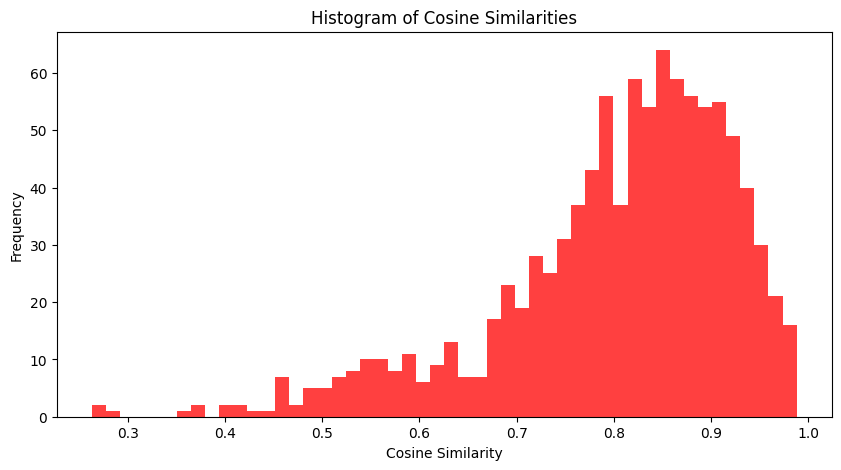

In [18]:
n_bins = 50  # You can change the number of bins based on how detailed you want the histogram to be
plt.figure(figsize=(10, 5))
plt.hist(similarities_CIFAR10, bins=n_bins, alpha=0.75, color='red')
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()

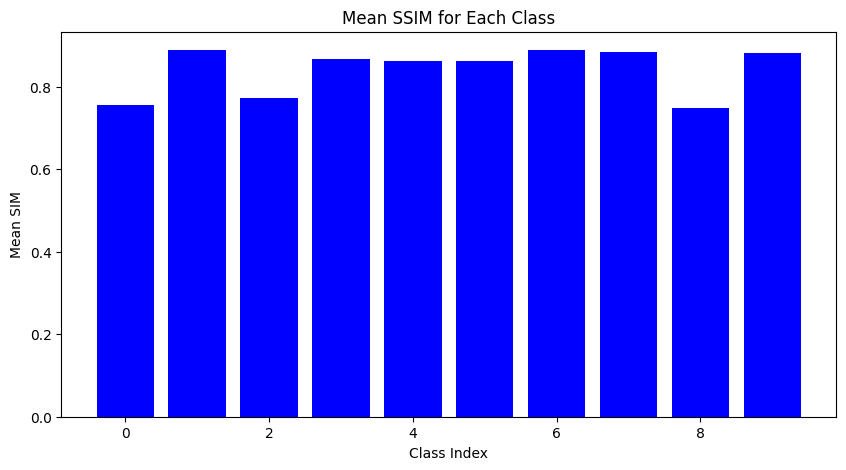

In [19]:
num_classes = 10
num_examples_per_class = 300

mean_sims = []  # saving SSIM scores for each class

for class_idx in range(num_classes):  # iterating over each class
	# Generate two sets of images for each class
	noise1 = torch.randn(num_examples_per_class, 100, device=device)
	noise2 = torch.randn(num_examples_per_class, 100, device=device)
	labels = torch.full((num_examples_per_class,), class_idx, device=device)
	labels_oh = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

	images1 = netG(noise1, labels_oh).detach()
	images2 = netG(noise2, labels_oh).detach()
	features1 = [get_features(image, feature_extractor) for image in images1]
	features2 = [get_features(image, feature_extractor) for image in images2]

	current_ssim = cosine_similarities(features1, features2)

	mean_sim = np.mean(current_ssim)
	mean_sims.append(mean_sim)


# Plot the mean SSIM values
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), mean_sims, color='blue')
plt.xlabel('Class Index')
plt.ylabel('Mean SIM')
plt.title('Mean SSIM for Each Class')
plt.show()

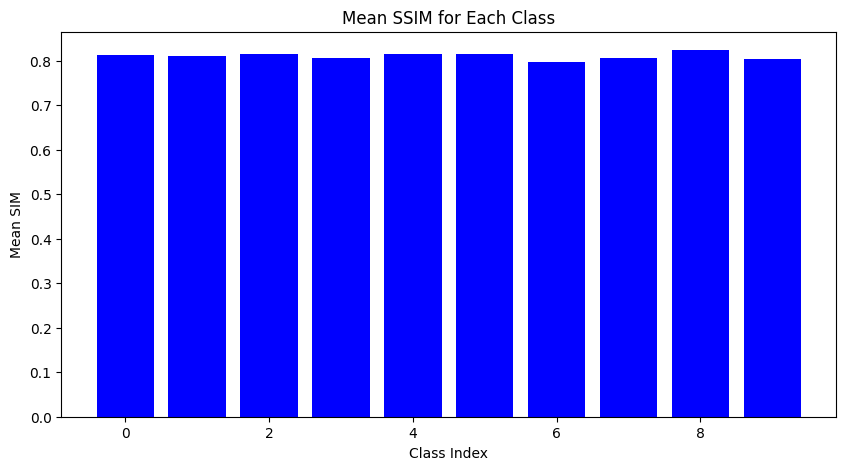

In [20]:
num_classes = 10
num_examples_per_class = 300

mean_sims_CIFAR10 = []  # saving SSIM scores for each class

for class_idx in range(num_classes):  # iterating over each class
	# Generate two sets of images for each class

	real_images, real_labels = get_images_labels(num_examples_per_class * 2, train_loader)
	images1 = real_images[:num_examples_per_class]
	images2 = real_images[num_examples_per_class:]
	features1 = [get_features(image, feature_extractor) for image in images1]
	features2 = [get_features(image, feature_extractor) for image in images2]

	current_ssim = cosine_similarities(features1, features2)

	mean_sim = np.mean(current_ssim)
	mean_sims_CIFAR10.append(mean_sim)
# print(f"Class {class_idx} Mean SSIM: {mean_ssim}")

# Plot the mean SSIM values
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), mean_sims_CIFAR10, color='blue')
plt.xlabel('Class Index')
plt.ylabel('Mean SIM')
plt.title('Mean SSIM for Each Class')
plt.show()

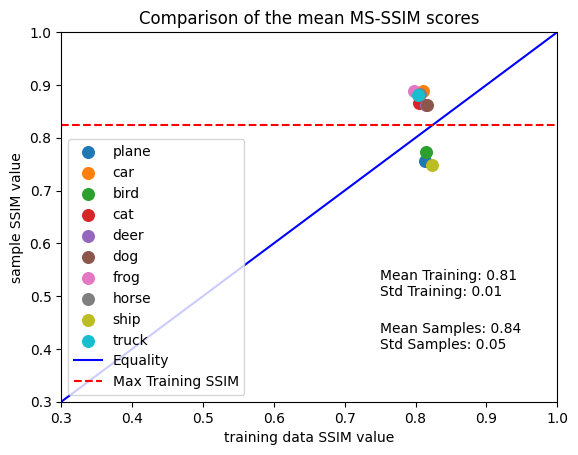

In [21]:
fig, ax = plt.subplots()

# calculating mean values and std errors
mean_train = np.mean(mean_sims_CIFAR10)
std_train = np.std(mean_sims_CIFAR10)
mean_samples = np.mean(mean_sims)
std_samples = np.std(mean_sims)

# Create scatter plot
for i in range(len(mean_sims_CIFAR10)):
	# each class has its own number and color
	ax.scatter(mean_sims_CIFAR10[i], mean_sims[i], label=f'{classes[i]}', s=70)
	# a = 5e-4
	# ax.text(mean_sims_CIFAR10[i] + a, mean_sims[i] + a, f'{i}', fontsize=10)

# Plot the line of equality
plt.plot([0, 1], [0, 1], 'b-', label='Equality')
# Plot the maximum SSIM value line
plt.axhline(y=max(mean_sims_CIFAR10), color='r', linestyle='--', label='Max Training SSIM')

# Annotations for mean and standard deviation
plt.text(0.75, 0.5, f'Mean Training: {mean_train:.2f}\nStd Training: {std_train:.2f}', color='black')
plt.text(0.75, 0.4, f'Mean Samples: {mean_samples:.2f}\nStd Samples: {std_samples:.2f}', color='black')
# Labels and title
plt.xlabel('training data SSIM value')
plt.ylabel('sample SSIM value')
plt.title('Comparison of the mean MS-SSIM scores')
plt.xlim(0.3, 1)
plt.ylim(0.3, 1)
# Legend
plt.legend()
# Show the plot
plt.show()